In [1]:
import pandas as pd

In [2]:
trips_hourly = pd.read_pickle('../00_data/trips_hourly.pkl')
trips_df = pd.read_pickle('../00_data/trips.pkl')

### Create available bikes feature

In [3]:
# we calculate the total number of ongoing trips
# we can use the number of ongoing trips of the previous hour as feature,
# because our task is to predict the total demand of the next hour
trips_hourly['trips_diff'] = trips_hourly['starting_trips'] - trips_hourly['ending_trips']
trips_hourly['ongoing_trips'] = trips_hourly['trips_diff'].cumsum() 
trips_hourly['ongoing_trips_prev'] = trips_hourly['ongoing_trips'].shift(1) # we can use this as predictor

In [4]:
trips_hourly = trips_hourly[['starting_trips', 'ongoing_trips_prev']]
trips_hourly = trips_hourly.dropna() # effectively drops first observation as ongoing trips prev does not exist

In [5]:
# get the number of unique bike_ids per week
trips_df['week'] = trips_df['start_time'].dt.isocalendar().week

bike_ids_week_grouped = (
    trips_df.groupby(["week"])['bike_id']
    .nunique()
    .to_frame("bike_ids_week")
)
bike_ids_week_grouped.mean()

bike_ids_week    757.346154
dtype: float64

In [6]:
bikes_df = trips_df.groupby("bike_id").agg(
    {
		"start_time": "min",
		"end_time": "max",
		 "bike_id": "count"
	}
)

# show bikes with latest start time and earliest end time
# indicates whether bikes are available constantly or not
trips_df[
			(trips_df["bike_id"] == bikes_df["start_time"].idxmax())
			| (trips_df["bike_id"] == bikes_df["end_time"].idxmin())
		]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,start_latitude,start_longitude,end_latitude,end_longitude,distance,speed,week
85,2019-01-01 11:07:00,2019-01-01 11:49:00,4210,4210,12043,Walk-up,Ocean Front Walk & North Venice,Ocean Front Walk & North Venice,0 days 00:42:00,33.98434,-118.47155,33.98434,-118.47155,0.000000,0.000000,1
144,2019-01-01 12:29:00,2019-01-01 12:52:00,4210,4210,12043,Walk-up,Ocean Front Walk & North Venice,Ocean Front Walk & North Venice,0 days 00:23:00,33.98434,-118.47155,33.98434,-118.47155,0.000000,0.000000,1
290267,2019-12-31 20:50:25,2019-12-31 20:58:42,4442,4436,6130,Annual Pass,Normandie & Sunset,Vermont & Franklin,0 days 00:08:17,34.09800,-118.30047,34.10578,-118.29194,1.032698,7.480307,1


In [7]:
bikes_df["start_time_floored"] = bikes_df["start_time"].dt.floor("1H")
bikes_df["end_time_floored"] = bikes_df["end_time"].dt.floor("1H") + pd.DateOffset(hours=1)

bikes_used_after = (
    bikes_df.groupby("start_time_floored").size().to_frame("bikes_used_after")
)
bikes_used_before = (
    bikes_df.groupby("end_time_floored").size().to_frame("bikes_used_before")
)

bikes_used = pd.concat([bikes_used_before, bikes_used_after], axis=1)
bikes_used = bikes_used.fillna(0)
bikes_used['diff'] = bikes_used['bikes_used_after'] - bikes_used['bikes_used_before'] 
bikes_used['in_service_bikes'] = bikes_used['diff'].cumsum()


<AxesSubplot:xlabel='start_time_floored', ylabel='in_service_bikes'>

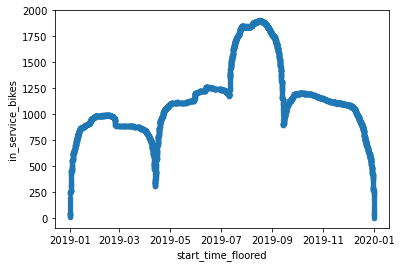

In [8]:
bikes_used = bikes_used.reset_index().rename(columns={"index": "start_time_floored"})
bikes_used.plot.scatter(x="start_time_floored", y="in_service_bikes")

In [9]:
bikes_used['in_service_bikes_rolling'] = bikes_used.rolling('30d', center=True, on='start_time_floored')['in_service_bikes'].max()

<AxesSubplot:xlabel='start_time_floored', ylabel='in_service_bikes_rolling'>

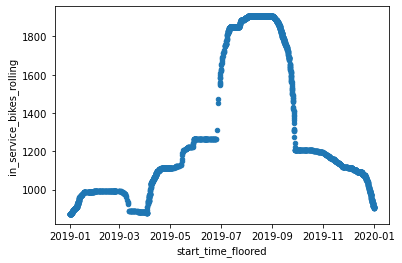

In [10]:
bikes_used.plot.scatter(x="start_time_floored", y="in_service_bikes_rolling")

In [11]:
bikes_used = bikes_used.set_index("start_time_floored")

In [12]:

bikes_used['in_service_bikes_rolling']

start_time_floored
2019-01-01 00:00:00    873.0
2019-01-01 01:00:00    873.0
2019-01-01 02:00:00    873.0
2019-01-01 03:00:00    873.0
2019-01-01 06:00:00    873.0
                       ...  
2019-12-31 20:00:00    905.0
2019-12-31 21:00:00    905.0
2019-12-31 22:00:00    905.0
2019-12-31 23:00:00    905.0
2020-01-01 00:00:00    905.0
Name: in_service_bikes_rolling, Length: 2917, dtype: float64

In [13]:
trips_hourly['in_service_bikes_rolling'] = bikes_used['in_service_bikes_rolling'].asfreq('1H', method="bfill")
trips_hourly.head(2)

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling
2019-01-01 01:00:00,8.0,2.0,873.0
2019-01-01 02:00:00,11.0,4.0,873.0


In [14]:
trips_hourly["available_bikes"] = (
    trips_hourly["in_service_bikes_rolling"] - trips_hourly["ongoing_trips_prev"]
)
trips_hourly.head(2)

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling,available_bikes
2019-01-01 01:00:00,8.0,2.0,873.0,871.0
2019-01-01 02:00:00,11.0,4.0,873.0,869.0


### Add weather features

In [15]:
weather_df = pd.read_pickle('../00_data/weather.pkl')

In [16]:
weather_df = weather_df.asfreq("1H", method="ffill")
weather_df.isna().sum()

max_temp    0
min_temp    0
precip      0
dtype: int64

In [17]:
trips_hourly['max_temp'] = weather_df['max_temp']
trips_hourly['min_temp'] = weather_df['min_temp']
trips_hourly['precip'] = weather_df['precip']

trips_hourly.head(2)

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling,available_bikes,max_temp,min_temp,precip
2019-01-01 01:00:00,8.0,2.0,873.0,871.0,15.6,15.6,0.0
2019-01-01 02:00:00,11.0,4.0,873.0,869.0,15.0,15.0,0.0


### Create time related features

In [18]:
# create time related features
trips_hourly['hour'] = trips_hourly.index.hour
trips_hourly['day_of_week'] = trips_hourly.index.day_of_week
trips_hourly['month'] = trips_hourly.index.month
trips_hourly['day_of_year'] = trips_hourly.index.day_of_year
trips_hourly['week'] = trips_hourly.index.isocalendar().week
trips_hourly['is_weekday'] = trips_hourly['day_of_week'] < 5

In [19]:
#TODO: add is_holiday feature
#TODO: add n_open_stations feature

In [20]:
trips_hourly.to_pickle('../00_data/trips_hourly_engineered.pkl')